In [36]:
from CB_02704 import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
# NormalizeGenotypeArray function takes in a genotype_array array and normalizes it (both mean and std dev)
def StandardizeGenotypeArray(genotype_array):
    p = genotype_array.mean(axis=1, keepdims = True)/2
    # print(p)
    genotype_array_standardized = (genotype_array-2*p)/np.sqrt(2*p*(1-p))
    genotype_array_standardized.set_fill_value(0)
    genotype_array_standardized = genotype_array_standardized.filled()
    return genotype_array_standardized

In [3]:
# FilterOutLowVarianceFeatures function takes in a genotype array (np masked array), and filters out the
# the features which have high variance and only keeps top_x_features 
def FilterLowVarianceFeatures(genotype_array, top_x_features):
    p = genotype_array.mean(axis=1).data/2
    # get the variance values assuming hardy-weinberg principle
    variance_values = 2*p*(1-p)
    # sort the variance values
    variance_indices_sorted = np.argsort(variance_values)[::-1] # the sorted values' indices in descending order

    # now just keep top_x_features number of indices
    genotype_array_filtered = genotype_array[variance_indices_sorted[:top_x_features], :]

    return genotype_array_filtered 

In [46]:
# PCA function takes in the genotype data (numpy masked array with snps as rownames and 
# individuals as colnames) and computes the PCA for that data
def PCA(genotype_array, top_x_features): 
    # first, subset the genotype_array to top_x_features number of features, so that we can do pca fast
    # the top features are chosen according to their variance
    genotype_array_filtered = FilterLowVarianceFeatures(genotype_array, top_x_features)

    # first mean centre (the features, which are snps in this case should have mean zero)
    # will use the StandardizeGenotype function from the assignments, hence also correcting variance
    genotype_array_standardized = StandardizeGenotypeArray(genotype_array_filtered)

    # then compute covariance matrix (it should have dimensions of features x features)
    cov = (1/genotype_array.shape[0])*(genotype_array_standardized @ genotype_array_standardized.T)
    
    # then compute eigenvalues and eigenvectors of the matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # eigenvalues, eigenvectors = sc.linalg.eigh(cov)


    # then perform projection of the datapoints in the direction of the two top eigenvectors
    # get the coordinate of each individual in the direction of the top eigenvector
    x_values = eigenvectors[:,-1] @ genotype_array_standardized
    # get the coordinate of each individual in the direction of the second top eigenvector
    y_values = eigenvectors[:,-2] @ genotype_array_standardized

    return x_values, y_values, eigenvalues, cov

In [15]:
# PlotVarianceOfFeatures function takes in a genotype array (np masked array), and plots the variance of
# the different snps. This is just to get an idea of how many snps may be less important while doing pca
def PlotVarianceOfFeatures(genotype_array):
    p = genotype_array.mean(axis=1).data/2
    # get the variance values assuming hardy-weinberg principle
    variance_values = 2*p*(1-p)
    # sort the variance values
    variance_values_sorted = np.sort(variance_values)[::-1] # the sorted values in descending order
    sns.lineplot(variance_values_sorted)
    plt.show()
    return

In [71]:
# PlotPCAResults function takes in the arrays for xvalues and yvalues of a set of points, and plots them
def PlotPCA(x_values, y_values, population_list):
    df = pd.DataFrame()
    df['x'] = x_values
    df['y'] = y_values
    df['population'] = population_list
    sns.scatterplot(df, x = 'x', y = 'y', hue='population')
    plt.show()
    return

In [58]:
pop_gen1 = read_geno_pop_chr('YRI', 1)
pop_gen2 = read_geno_pop_chr('CEU', 1)
pop_gen3 = read_geno_pop_chr('JPT', 1)

In [67]:
# make the list storing information of which population each individual belongs to
population_list = ['YRI']*pop_gen1.shape[1] + ['CEU']*pop_gen2.shape[1] + ['JPT']*pop_gen3.shape[1]

In [68]:
# horizontally stack the three populations
pop_gen = np.ma.hstack([pop_gen1, pop_gen2, pop_gen3])

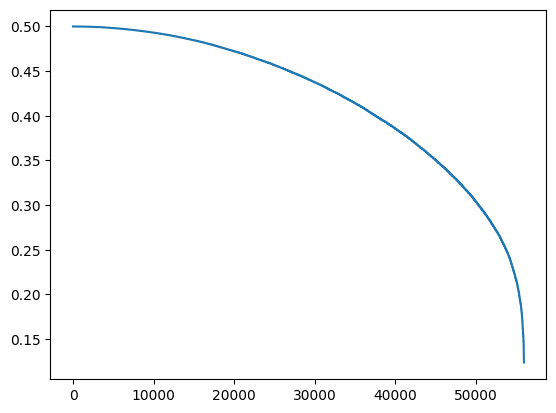

In [69]:
PlotVarianceOfFeatures(pop_gen)

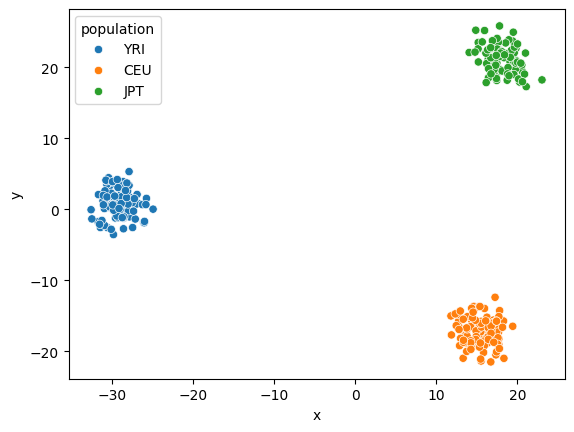

In [72]:
x_values, y_values, eigenvalues, cov = PCA(pop_gen, top_x_features=3000)
PlotPCA(x_values, y_values, population_list)